# GPT2 124M DDP

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

from gollem.models.gpt2.config import get_gpt2_model_config
from gollem.gpu_stats import get_gpu_flops


model_cfg = get_gpt2_model_config("gpt2")
gpu_name = "H100"
dtype = "bfloat16"

# full_batch size = 524K
# single_mini_batch size = 64K (i.e. 1 grad step)
df = pd.DataFrame(
    columns=["num_gpus", "single_mini_batch_tps", "full_batch_tps", "grad_steps"],
    data=(
        (8, 3_046_409, 3_046_409, 1),
        (4, 1_526_010, 1_595_618, 2),
        (2, 782_975, 825_314, 4),
        (1, 412_307, 418_821, 8),
    ),
)


def compute_full_batch_mfu(row):
    model_flops_per_token = model_cfg.compute_flops().total / model_cfg.n_ctx
    gpu_flops = get_gpu_flops(gpu_name, dtype)
    per_gpu_tps = row["full_batch_tps"] / row["num_gpus"]
    return 100 * (model_flops_per_token * per_gpu_tps) / gpu_flops


def compute_single_mini_batch_mfu(row):
    model_flops_per_token = model_cfg.compute_flops().total / model_cfg.n_ctx
    gpu_flops = get_gpu_flops(gpu_name, dtype)
    per_gpu_tps = row["single_mini_batch_tps"] / row["num_gpus"]
    return 100 * (model_flops_per_token * per_gpu_tps) / gpu_flops


df["single_mini_batch_mfu"] = df.apply(compute_single_mini_batch_mfu, axis=1)
df["full_batch_mfu"] = df.apply(compute_full_batch_mfu, axis=1)

df

,num_gpus,single_mini_batch_tps,full_batch_tps,grad_steps,single_mini_batch_mfu,full_batch_mfu
0,8,3046409,3046409,1,32.898999,32.898999
1,4,1526010,1595618,2,32.959594,34.463026
2,2,782975,825314,4,33.822240,35.651161
3,1,412307,418821,8,35.620923,36.183695


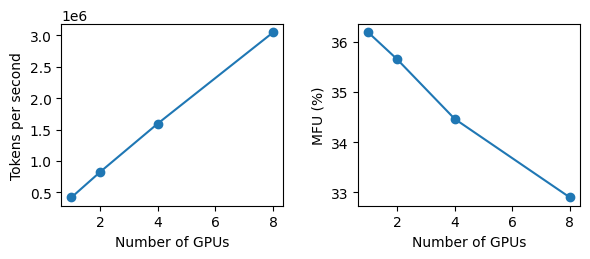

In [32]:
# Plot the results in a single figure
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Plot full batch mfu
for ax, label, key in zip(
    ax.flatten(),
    ["Tokens per second", "MFU (%)"],
    ["full_batch_tps", "full_batch_mfu"],
):
    ax.plot(df["num_gpus"], df[key], label=line_label, marker="o")
    ax.set_xlabel("Number of GPUs")
    ax.set_ylabel(label)

# add some space between the legend and the plot
fig.tight_layout(rect=(0, 0.1, 1, 1.0))

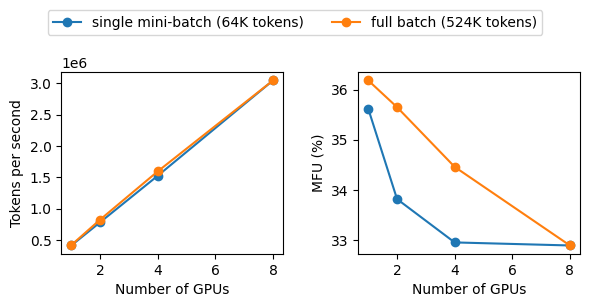

In [30]:
# Plot the results in a single figure
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Plot full batch mfu
for ax, label, keys in zip(
    ax.flatten(),
    ["Tokens per second", "MFU (%)"],
    [
        ("single_mini_batch_tps", "full_batch_tps"),
        ("single_mini_batch_mfu", "full_batch_mfu"),
    ],
):
    for key in keys:
        line_label = (
            "full batch (524K tokens)"
            if "full" in key
            else "single mini-batch (64K tokens)"
        )
        ax.plot(df["num_gpus"], df[key], label=line_label, marker="o")
    ax.set_xlabel("Number of GPUs")
    ax.set_ylabel(label)

# Add a single legend for the full and mini batch lines
lines, labels = ax.get_legend_handles_labels()
fig.legend(lines, labels, loc="lower center", ncol=2, bbox_to_anchor=(0.5, 1.0))
# add some space between the legend and the plot
fig.tight_layout(rect=(0, 0.1, 1, 1.0))
